In [69]:
import pandas as pd
import numpy as np
import xgboost as xgb
import types

#
#    This is just the estimator which fits four separate estimators on the entire DataFrame.
#    When predicting it splits pandas dataframe by column 'labels' and for each group
#    returns the prediction of corresponding estimator
#
from sep_estimator import sep_estimator

#
#    This class finds the cluster labels. See kernel on kaggle:
#    https://www.kaggle.com/daniel89/mercedes-cars-clustering/
#
from cluster_target_encoder import cluster_target_encoder
from scipy import stats
from sklearn.cluster import KMeans

In [70]:
train = pd.read_csv('../input/train.csv')
X_test = pd.read_csv('../input/test.csv')
X_train = train.drop(['y'],axis=1)
y_train = train['y']

Here we find the cluster labels

In [71]:
encoder = cluster_target_encoder(nclusters=4,seed=4)
labels_train = encoder.fit_transform(X_train['X0'],train['y'])
labels_test = encoder.transform(X_test['X0'])
est = xgb.XGBClassifier()
est.fit(X_train.select_dtypes(include=[np.number]),labels_train)
labels_test[np.isnan(labels_test)] = est.predict(
    X_test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]
X_train['labels'] = labels_train
X_test['labels'] = labels_test

Let's glance at the target's distributions for our clusters. They obviously represent different components of the distribution. The core idea is that to predict each of these components we may need different subset of features, different parameters of the algorithm, even may be different algorithm.

Populating the interactive namespace from numpy and matplotlib


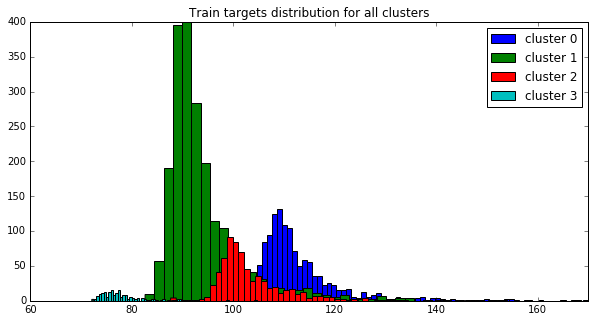

In [74]:
%pylab inline
plt.figure(figsize(10,5))
plt.hist(y_train.values[X_train['labels']==0],bins=70,label='cluster 0')
plt.hist(y_train.values[X_train['labels']==1],bins=100,label='cluster 1')
plt.hist(y_train.values[X_train['labels']==2],bins=70,label='cluster 2')
plt.hist(y_train.values[X_train['labels']==3],bins=70,label='cluster 3')
plt.legend()
plt.title('Train targets distribution for all clusters')
plt.xlim((60,170))
plt.show()

Now back to our features

In [75]:
#
#   Just drop X4 because is is almost constant
#

if 'X4' in X_train.columns.values:
    X_train = X_train.drop('X4',axis=1)
if 'X4' in X_test.columns.values:
    X_test = X_test.drop('X4',axis=1)

#
#   Drop binary features with zero standard deviation
#

zero_std = X_train.std()[X_train.std()==0].index
X_train = X_train.drop(zero_std,axis=1)
X_test = X_test.drop(zero_std,axis=1)

#
#   Drop features with statistically significant difference of means
#   in train and test. Well, I'm aware about normality assumption in ttest_rel,
#   but in case of 4200 samples the sample average is almost normally
#   distributed, the sample variance is almost chi2 distributed
#   and actually ttest is almost like ztest.
#

different_cols = []
for c in X_train.select_dtypes(include=[np.number]).columns:
    tt = stats.ttest_ind(X_train[c],X_test[c])
    if tt[1]<0.05:
        different_cols.append(c)
X_train = X_train.drop(different_cols,axis=1)
X_test = X_test.drop(different_cols,axis=1)

#
#   Drop all categorical features except our clusters ('labels')
#

X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])
cols = X_train.columns.drop('labels').values
cols_all = X_train.columns.values

#
#   This little estimator returns the groupmean of y by X['labels']
#

class est_mean:
    def __init__(self,label):
        self.label = label
    def fit(self,X,y):
        self.answer = y[X['labels']==self.label].mean()
    def predict(self,X):
        assert (X['labels']==self.label).all()
        res = np.ones(shape=(len(X)))
        res = res*self.answer
        return res

In [76]:
pred_df = pd.DataFrame(index=X_test.index)
for i in range(100):
    params3 = {'label':3}
    params2 = {
        'n_estimators': 90, 
        'learning_rate': 0.1,
        'max_depth': 2,
        'gamma': 25,
        'subsample': 0.9,
        'colsample_bytree':0.6,
        'colsample_bylevel':0.8,
        'objective': 'reg:linear',
        'silent': 1,
        'seed':i
    }
    params1 = {
        'n_estimators': 80, 
        'learning_rate': 0.1,
        'max_depth': 2,
        'gamma': 30,
        'subsample': 0.8,
        'colsample_bytree':0.6,
        'colsample_bylevel':0.8,
        'objective': 'reg:linear',
        'silent': 1,
        'seed':i
    }
    params = {
        'n_estimators': 90, 
        'learning_rate': 0.1,
        'max_depth': 2,
        'gamma': 20,
        'subsample': 0.9,
        'colsample_bytree':0.6,
        'colsample_bylevel':0.9,
        'objective': 'reg:linear',
        'silent': 1,
        'seed':i
    }
    
#
#   Iteresting stuff here. For the cluster X['label']==3 we can do absolutely nothing.
#   For every object of this cluster we just return the cluster's target mean (est3=est_mean).
#   Clusters 1 and 2 are getting overfitted if they look into the labels feature, that's why
#   we give them only cols which are all columns except 'labels'.
#   For cluster 0 the 'labels' feature has crucial importance, that's why we give it cols_all
#

    reg = sep_estimator(params,params1,params2,params3,
                    cols_all,
                    cols,
                    cols,
                    ['labels'],
                    est3=est_mean)
    reg.fit(X_train,y_train)
    pred_df[str(i)] = reg.predict(X_test)
    if i%10==0:
        print i
sub = pd.DataFrame()
sub['ID'] = X_test['ID']
sub['y'] = pred_df.mean(axis=1)
sub.to_csv('submit_mercedes_11_place.csv', index=False)
sub.head()

0
10
20
30
40
50
60
70
80
90


,ID,y
0,1,77.964862
1,2,100.581468
2,3,77.964862
3,4,77.964862
4,5,115.189239


Here is how we are doing for different clusters in test.

Populating the interactive namespace from numpy and matplotlib


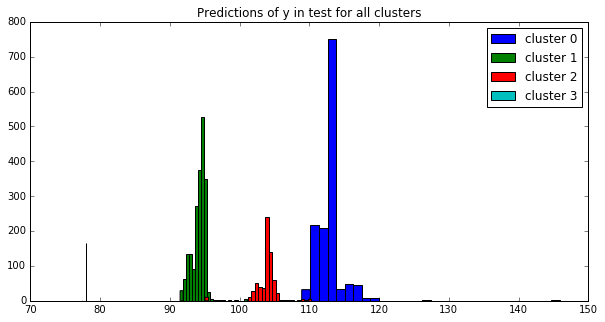

In [77]:
%pylab inline
plt.figure(figsize(10,5))
plt.hist(sub['y'].values[X_test['labels']==0],bins=30,label='cluster 0')
plt.hist(sub['y'].values[X_test['labels']==1],bins=30,label='cluster 1')
plt.hist(sub['y'].values[X_test['labels']==2],bins=30,label='cluster 2')
plt.hist(sub['y'].values[X_test['labels']==3],bins=30,label='cluster 3')
plt.legend()
plt.title('Predictions of y in test for all clusters')
plt.show()